In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import sys
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Make sure exercises are in the path
chapter = r"chapter1_transformer_interp"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part4_superposition_and_saes"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, hist
from utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
)


device = t.device("cuda" if t.cuda.is_available() else "cpu")


In [ ]:
def plot_vector_groups(tensor, group_titles=None):
    num_groups = tensor.shape[0]
    num_vectors = tensor.shape[2]
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']
    fig, axes = plt.subplots(1, num_groups, figsize=(4 * num_groups, 4))
    
    # Create a list to store the legend handles and labels
    legend_handles = []
    legend_labels = []
    
    for i in range(num_groups):
        ax = axes[i]
        group = tensor[i]
        for j in range(num_vectors):
            vector = group[:,j]
            color = colors[j % len(colors)]
            handle = ax.quiver(0, 0, vector[0], vector[1], angles='xy', scale_units='xy', scale=1, color=color,width=0.03, headwidth=5, headlength=7)
            
            if i == 0:
                legend_handles.append(handle)
                legend_labels.append(f'Vector {j+1}')
        
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')
        
        if group_titles is not None and i < len(group_titles):
            ax.set_title(group_titles[i])
        else:
            ax.set_title(f'Group {i+1}')
    
    # Create a single legend at the side
    fig.legend(legend_handles, legend_labels, loc='center right', bbox_to_anchor=(1.0, 0.5), prop={'size': 25})
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Adjust the right margin to make space for the legend
    plt.show()

In [7]:
def get_angle(d, n):
    def equation(x):
        return d - (np.cos(x) - np.sin(x)/np.sqrt(n))**2
    
    # Initial guess for x
    x0 = 0
    
    # Solve the equation numerically
    solution = fsolve(equation, x0)
    
    return solution[0]

In [8]:
zero_angle = get_angle(0, 10)
print(f"Zero angle: {zero_angle:.2f} rad")
one_angle = get_angle(1, 10)
print(f"One angle: {one_angle:.2f} rad")

Zero angle: 1.26 rad
One angle: 0.00 rad


In [13]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class Config:
    # We optimize n_instances models in a single training loop to let us sweep over
    # sparsity or importance curves  efficiently. You should treat `n_instances` as
    # kinda like a batch dimension, but one which is built into our training setup.
    n_instances: int
    n_features: int = 5
    n_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0


class Model(nn.Module):
    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]
    # Our linear map is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]] = None,
        importance: Optional[Union[float, Tensor]] = None,
        device = device,
        groupings: Optional[List[Tuple[List[int], float]]] = None,
    ):
        super().__init__()
        self.cfg = cfg
        self.groupings = groupings

        self.accuracy_matrix = t.diag(t.ones(cfg.n_features)).to(device)
        if groupings is not None:
            for grou_members, semantic_distance in groupings:
                n_group = len(grou_members)
                angle = get_angle(semantic_distance, n_group)
                print(f"Group members: {grou_members}, angle: {angle:.2f}")
                for i in grou_members:
                    for j in grou_members:
                        if i == j:
                            self.accuracy_matrix[i, j] = np.cos(angle)
                        else:
                            self.accuracy_matrix[i, j] = np.sin(angle)/n_group
        if feature_probability is None: feature_probability = t.ones(())
        if isinstance(feature_probability, float): feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_instances, cfg.n_features))
        if importance is None: importance = t.ones(())
        if isinstance(importance, float): importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))
        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features)))
        self.to(device)




    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:

        hidden_layer = t.einsum("...if,ihf->...ih", features, self.W)
        return F.relu(t.einsum("...ih,ihf->...if", hidden_layer, self.W) + self.b_final)


    def generate_batch(self, batch_size) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of data. We'll return to this function later when we apply correlations.
        '''
        # Generate the features, before randomly setting some to zero
        feat = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features), device=self.W.device)
        # Generate a random boolean array, which is 1 wherever we'll keep a feature, and zero where we'll set it to zero
        feat_seeds = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features), device=self.W.device)
        feat_is_present = feat_seeds <= self.feature_probability
        # Create our batch from the features, where we set some to zero
        batch = t.where(feat_is_present, feat, 0.0)

        if self.groupings is not None:
            for group_members, _ in self.groupings:
                lst = t.tensor(group_members)
                random_indices = t.randint(0, len(lst), (batch_size,  self.cfg.n_instances))
                random_indices = lst[random_indices]
                # Create a mask tensor with the same shape as generated_data
                mask = t.ones_like(batch, dtype=t.bool)
                mask[:, :, lst] = False
                # Set the selected indices in the mask to True
                mask[t.arange(batch_size).unsqueeze(1), t.arange( self.cfg.n_instances), random_indices] = True
                #set all features to true not on lst


                # Set the selected features to their original values and the rest to zero
                batch = t.where(mask, batch, t.zeros_like(batch))

        return batch


    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        '''
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Remember, `model.importance` will always have shape (n_instances, n_features).
        '''

        diff = out - batch
        rotated_diff = t.einsum("bin,fn->bif", diff, self.accuracy_matrix)
        total_diff = (rotated_diff ** 2 * self.importance).sum(dim = -1)
        return total_diff.mean()
    


    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        '''
        Optimizes the model using the given hyperparameters.
        '''
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item()/self.cfg.n_instances, lr=step_lr)

In [23]:
cfg = Config(
    n_instances = 8,
    n_features = 5,
    n_hidden = 2,
)

# importance varies within features for each instance
#importance = t.ones((1, cfg.n_features))

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = (50 ** -t.linspace(0, 1, cfg.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

#line(importance.squeeze(), width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability.squeeze(), width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [24]:
groupings = [([0,1,2],.7)]

In [25]:
feature_probability = t.ones(cfg.n_instances)*0.3
feature_probability = feature_probability.unsqueeze(1)

In [26]:
importance = (0.9 ** t.arange(cfg.n_features))
importance = einops.rearrange(importance, "features -> () features")

In [27]:
model = Model(
    cfg = cfg,
    device = device,
    feature_probability = feature_probability,
    importance = importance,
    groupings = groupings,
)
model.accuracy_matrix 

Group members: [0, 1, 2], angle: 0.24


tensor([[0.9721, 0.0782, 0.0782, 0.0000, 0.0000],
        [0.0782, 0.9721, 0.0782, 0.0000, 0.0000],
        [0.0782, 0.0782, 0.9721, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])

  0%|          | 0/10000 [00:00<?, ?it/s]

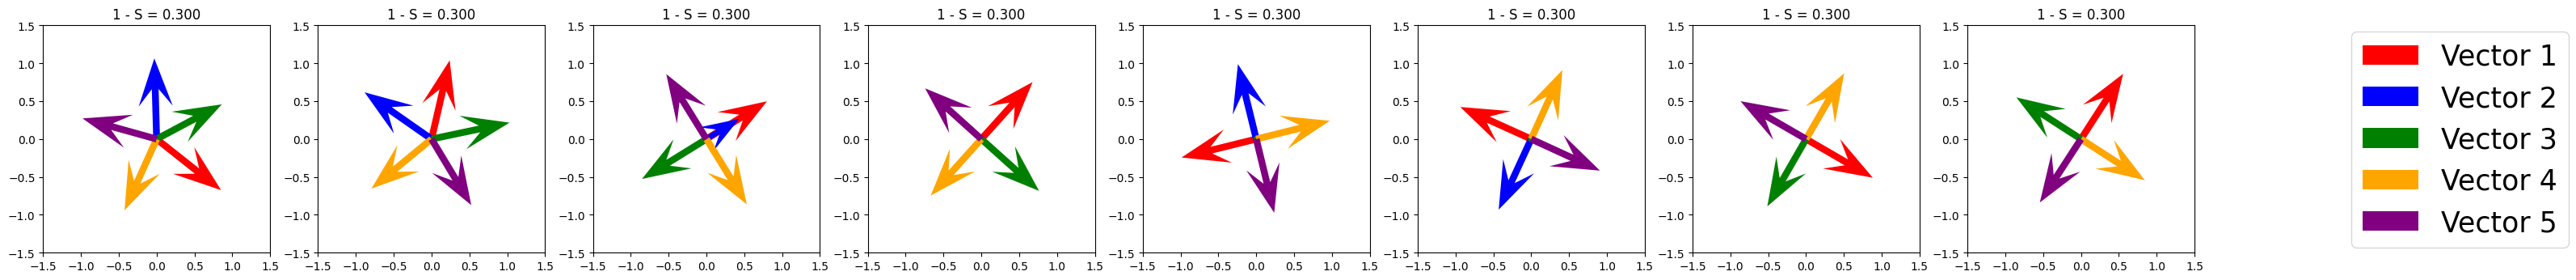

In [28]:

model.optimize(steps=10000)

titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()]
plot_vector_groups(model.W.detach(), group_titles=titles)

In [29]:
for W in model.W.detach():
    W_normed = W / W.norm(dim=0, keepdim=True)
    imshow(W_normed.T @ W_normed, title="Cosine similarities of each pair of 2D feature embeddings", width=600)
    

In [90]:
model.W.detach()

tensor([[[ 0.0010,  0.0010,  0.0010,  0.8969,  0.4419],
         [ 0.0012,  0.0012,  0.0012,  0.4417, -0.8972]],

        [[-0.0015, -0.0015, -0.0015, -0.7108, -0.7031],
         [ 0.0013,  0.0013,  0.0013, -0.7030,  0.7117]],

        [[ 0.5035,  0.4928,  0.4951, -0.9605, -0.3727],
         [-0.2022, -0.1995, -0.1994,  0.3843, -0.9276]],

        [[-0.4302, -0.4342, -0.4286, -0.6429,  0.7837],
         [-0.3604, -0.3638, -0.3590,  0.7665,  0.6565]],

        [[ 0.1789,  0.1833,  0.1813,  0.9492, -0.3226],
         [ 0.5371,  0.5433,  0.5449, -0.3171, -0.9603]],

        [[ 0.4009,  0.4046,  0.4043,  0.7094, -0.7137],
         [ 0.4037,  0.4077,  0.4072, -0.7052, -0.7174]],

        [[ 0.4362,  0.4438,  0.4308, -0.7626, -0.6523],
         [ 0.3739,  0.3816,  0.3688, -0.6583,  0.7581]],

        [[-0.4088, -0.4116, -0.4095,  0.7125, -0.7037],
         [ 0.4047,  0.4075,  0.4055, -0.7042, -0.7107]]])

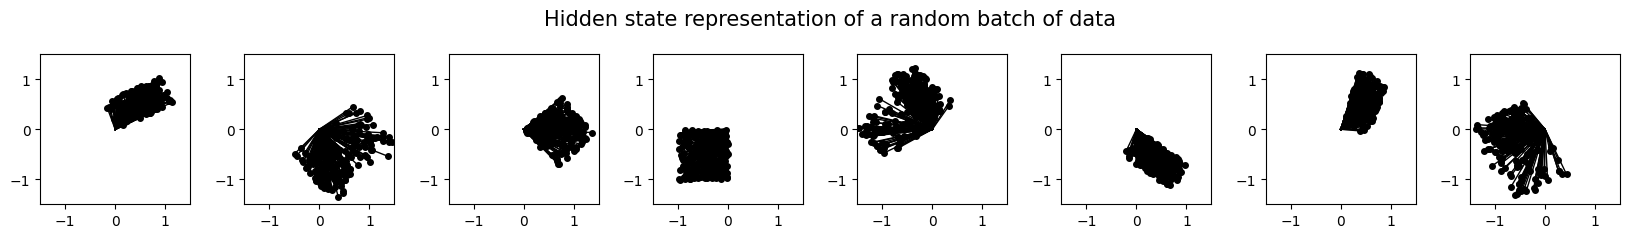

In [142]:
with t.inference_mode():
    batch = model.generate_batch(200)
    hidden = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> instances hidden batch_size")

plot_features_in_2d(hidden, title = "Hidden state representation of a random batch of data")

In [34]:
n_features = 80
n_hidden = 20

groupings = [([8,9,10],.1)]

importance = (0.9 ** t.arange(n_features))
importance = einops.rearrange(importance, "features -> () features")

feature_probability = t.tensor([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001])
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

cfg = Config(
    n_instances = len(feature_probability.squeeze()),
    n_features = n_features,
    n_hidden = n_hidden,
)

line(importance.squeeze(), width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability.squeeze(), width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
    groupings = groupings,
)
model.optimize(steps=10_000)

Group members: [8, 9, 10], angle: 0.77


  0%|          | 0/10000 [00:00<?, ?it/s]

In [33]:
plot_features_in_Nd(
    model.W,
    height = 600,
    width = 1400,
    title = "ReLU output model: n_features = 80, d_hidden = 20, I<sub>i</sub> = 0.9<sup>i</sup>",
    subplot_titles = [f"Feature prob = {i:.3f}" for i in feature_probability[:, 0]],
)